<a href="https://colab.research.google.com/github/tunakan12/graph_algorithm/blob/main/cDA25_06_%E6%BC%94%E7%BF%92%E8%AA%B2%E9%A1%8C_%E3%82%AF%E3%82%99%E3%83%A9%E3%83%95_%E5%AE%8C%E6%88%90%E7%89%88_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# コンパイル時のエラーメッセージの日本語化

下のコードセルを実行しておく


In [68]:
!sudo apt-get install gettext >/dev/null 2>&1
!wget -c https://github.com/gcc-mirror/gcc/raw/releases/gcc-11/gcc/po/ja.po >/dev/null 2>&1
!msgfmt -o gcc-11.mo ja.po
!cp gcc-11.mo /usr/share/locale/en/LC_MESSAGES/
!rm -f gcc-11.mo ja.po

# コード

## 構造体宣言
### グラフ：Node_Gr型
一つの構造体変数は一つのノードに対応し、下のデータを保持
- 整数型のノードID
- 隣接ノードへのポインタの配列
  - 配列サイズが maxdeg
- どのノードを経由してこのノードに到達したか。

### スタックとキュー
次に探索するノードを記録するために利用する。そのため、Node_Gr型のアドレスを記録する。


In [69]:
%%file dfsbfs.h
//グラフの最大次数
#define maxdeg 100
//Stk, Queのサイズ
#define mmaxsize 20000
// graphのノードを表す構造体
typedef struct node_gr {
    int id;                // id
    int adj_size;          // 隣接ノード数
    struct node_gr **adj;  // 隣接ノードポインタの配列（最大maxdeg）
    struct node_gr *parent;// 経路の親ノードポインタ
    int *adj_weights;      // 隣接ノードごとの枝の重み配列（最大maxdeg）
    int dist;              // Dijkstra用：始点からの距離
    int flag;              // Dijkstra用：最短距離確定
    int checked;           // ノードがアクセスされバッファに格納
} Node_Gr;

//------
typedef struct stk{
    int maxsize;
    int sp;
    Node_Gr* stack[mmaxsize];
} Stk;

typedef struct que{
    int maxsize;
    int size;
    int wp;
    int rp;
    Node_Gr* queue[mmaxsize];
} Que;

void push(Stk *pstk1, Node_Gr *dat);
Node_Gr* pop(Stk *pstk1);
void enq(Que *pque1, Node_Gr* dat);
Node_Gr* deq(Que *pque1);
Node_Gr* min_dist_deq(Que *pque1);
Stk *create_stack();
Que *create_queue();
void append(Node_Gr *src, Node_Gr *dst, int weight);
Node_Gr **make_undirected_graph(int node_size, int num_edge, double p_random);
Node_Gr **make_arbitrary_digraph(int *node_size_ad);
void delete_graph(Node_Gr** nodes, int node_size);
void print_adjacency_info(Node_Gr **nodes, int node_size);
void print_graph_info(Node_Gr **nodes, int node_size);
void print_weighted_graph_info(Node_Gr **nodes, int node_size, int no);
void print_digraph_info(Node_Gr **nodes, int node_size);
void print_path(Node_Gr *node);
void dfs_search(Node_Gr *start, int target, int node_size);
Node_Gr * dfs_search_rec(Node_Gr *start, int target);
void dfs_search2(Node_Gr *start, int target, int node_size);
void bfs_search(Node_Gr *start, int target, int node_size);
void dijkstra(Node_Gr *start, Node_Gr **nodes, int node_size);
void printpush(Stk *p_stk, Node_Gr *dat);
void printpop(Stk *p_stk, Node_Gr *dat);
void printenq(Que *p_que, Node_Gr *dat);
void printdeq(Que *p_que, Node_Gr *dat);
void print_mindist_deq(Que *p_que, Node_Gr *dat);
void topological_sort(Node_Gr **nodes, int node_size);

Overwriting dfsbfs.h


## スタックとキューの操作の実装
push,pop,enq,deq共にこれまでとほとんど変化してない。

扱うデータがNode_Gr型のアドレスになったため、その点のみ変更。


In [70]:
%%file stkque.c
#include<stdio.h>
#include<stdlib.h>
#include<limits.h>
#include "dfsbfs.h"
void push(Stk *pstk1, Node_Gr *dat){
    if(pstk1->sp==pstk1->maxsize){
        printf("*** stack overflow ***\n");
        exit(1);
    }
    pstk1->stack[pstk1->sp]=dat;
    pstk1->sp++;
}

Node_Gr* pop(Stk *pstk1){
    Node_Gr* dat;
    if(pstk1->sp==0){
        printf("*** stack empty ***\n");
        exit(1);
    }
    (pstk1->sp)--;
    dat=pstk1->stack[pstk1->sp];
    return(dat);
}

void enq(Que *pque1, Node_Gr* dat){
    if(pque1->size==pque1->maxsize){
        printf("*** warning:queue overflow ***\n");
        printf("%d %d\n", pque1->size, pque1->maxsize);
        exit(1);
    }
    pque1->queue[pque1->wp]=dat;
    pque1->wp=((pque1->wp)+1)%(pque1->maxsize);
    pque1->size++;
}

Node_Gr* deq(Que *pque1){
    Node_Gr* dat;
    if(pque1->size==0){
        printf("*** warning:queue empty ***\n");
        printf("%d %d\n", pque1->size, pque1->maxsize);
        return(NULL);
    }
    dat=pque1->queue[pque1->rp];
    pque1->rp=((pque1->rp)+1)%(pque1->maxsize);
    pque1->size--;
    return(dat);
}

// added for dijkstra
Node_Gr* min_dist_deq(Que *pque1){
    Node_Gr* dat;
    int min,d,min_ind,i;
    if(pque1->size==0){
        printf("*** warning:queue empty ***\n");
        printf("%d %d\n", pque1->size, pque1->maxsize);
        return(NULL);
    }

    min=INT_MAX;
    for(i=0;i<pque1->size;i++){
        d=pque1->queue[(pque1->rp+i) %(pque1->maxsize)]->dist;
        if(min>d){
            min_ind=i;
            min=d;
        }
    }

    dat=pque1->queue[(pque1->rp+min_ind) %(pque1->maxsize)];

    // shift
    for(i=min_ind+1;i < pque1->size;i++){
        pque1->queue[(pque1->rp+i-1) %(pque1->maxsize)]=pque1->queue[(pque1->rp+i) %(pque1->maxsize)];
    }
    pque1->wp=((pque1->wp)-1)%(pque1->maxsize);
    pque1->size--;
    return(dat);
}

Stk *create_stack(){
    Stk *pstk1;
    pstk1=(Stk*)malloc(sizeof(Stk));
    if(pstk1==NULL){exit(1);}
    pstk1->maxsize=mmaxsize;
    pstk1->sp=0;
    return pstk1;
}

Que *create_queue(){
    Que *pque1;
    pque1=(Que*)malloc(sizeof(Que));
    if(pque1==NULL){exit(1);}
    pque1->maxsize=mmaxsize;
    pque1->wp=0;
    pque1->rp=0;
    pque1->size=0;
    return pque1;
}

void printpush(Stk *p_stk, Node_Gr *dat){ //push処理の出力
    printf("                                   push:[ ");
    for(int i=0; i<p_stk->sp; i++){printf("%2d ", p_stk->stack[i]->id);}
    printf("]\n");
    printf("                                          ");
    for(int i=0; i<p_stk->sp; i++){printf("   ");}
    printf("sp\n");
    //printf("      sp=%d, dat=%d\n", p_stk->sp, dat->id);
}

void printpop(Stk *p_stk, Node_Gr *dat){
    printf("                                   pop: [ ");
    for(int i=0; i<p_stk->sp; i++){printf("%2d ", p_stk->stack[i]->id);}
    printf("] --> %2d\n", dat->id);
    printf("                                          ");
    for(int i=0; i<p_stk->sp; i++){printf("   ");}
    printf("sp\n");
    //printf("%d <- sp=%d\n", dat, p_stk->sp);
}

void printenq(Que *p_que, Node_Gr *dat){
    printf("enqueue:  [ ");
    if(p_que->rp < p_que->wp){
        for(int i=p_que->rp; i<p_que->wp; i++){
            printf("%2d ", p_que->queue[i]->id);}
    }
    else{
        for(int i=p_que->rp; i<p_que->maxsize; i++){
            printf("%2d ", p_que->queue[i]->id);}
        for(int i=0; i<p_que->wp; i++){
            printf("%2d ", p_que->queue[i]->id);}
    }
    printf("] \n");
}

void printdeq(Que *p_que, Node_Gr *dat){
    printf("dequeue:  [ ");
    if(p_que->rp < p_que->wp || p_que->size==0){
        for(int i=p_que->rp; i<p_que->wp; i++){
            printf("%2d ", p_que->queue[i]->id);}
    }
    else{
        for(int i=p_que->rp; i<p_que->maxsize; i++){
            printf("%2d ", p_que->queue[i]->id);}
        for(int i=0; i<p_que->wp; i++){
            printf("%2d ", p_que->queue[i]->id);}
    }
    printf("] --> %2d \n", dat->id);
}

void print_mindist_deq(Que *p_que, Node_Gr *dat){
    printf("min_deq:  [ ");
    if(p_que->rp < p_que->wp || p_que->size==0){
        for(int i=p_que->rp; i<p_que->wp; i++){
            printf("%2d ", p_que->queue[i]->id);}
    }
    else{
        for(int i=p_que->rp; i<p_que->maxsize; i++){
            printf("%2d ", p_que->queue[i]->id);}
        for(int i=0; i<p_que->wp; i++){
            printf("%2d ", p_que->queue[i]->id);}
    }
    printf("] --> %2d \n", dat->id);
}


Overwriting stkque.c


## グラフ生成処理


### グラフ関連処理
make_undirected_graph関数で、無向グラフを作成し、print_graphiz_info関数でグラフを描画するpythonコードを生成



In [71]:
%%file graphsub.c
#include<stdlib.h>
#include<stdio.h>
#include "dfsbfs.h"

// srcノードからdstノードへ枝をつなげる
// [入力] src,dst はノードのアドレス
// [出力] なし
void append(Node_Gr *src, Node_Gr *dst, int weight){
  int i;
  if(src==NULL || dst==NULL) exit(1);

  //自分自身とは接続しない
  if(src == dst) return;

  for(i=0; i<src->adj_size; i++)
    if(src->adj[i]==dst) break;
  if(i == src->adj_size){
      if(src->adj_size >= maxdeg){printf("maxdeg error\n"); exit(1);}
      src->adj[ src->adj_size ] = dst;
      src->adj_weights[ src->adj_size ] = weight;
      src->adj_size += 1;
  }
}

// ノードの構造体のメモリを確保し、idを設定
// [入力] id: 整数型
// [出力] new_node: 追加ノードアドレス
Node_Gr *malloc_node_gr(int id){
    int i;
    Node_Gr *new_node;
    Node_Gr **new_adj;
    int *new_adj_weights;
    new_node = (Node_Gr*)malloc(sizeof(Node_Gr));
    if(new_node == NULL) {printf("malloc error\n"); exit(1);}

    new_adj    = (Node_Gr**)malloc(maxdeg * sizeof(Node_Gr*));
    new_adj_weights = (int*)malloc(maxdeg * sizeof(int));
    if(new_adj == NULL || new_adj_weights == NULL) {printf("malloc error\n"); exit(1);}
    for(i=0;i<maxdeg;i++){
        new_adj[i] = NULL;
        new_adj_weights[i] = 0;
    }

    new_node->adj         = new_adj;        //隣接ノード配列
    new_node->adj_weights = new_adj_weights;//隣接ノード重み配列
    new_node->id = id;
    new_node->adj_size = 0;                 //初期隣接登録数 ０
    new_node->parent = NULL;
    new_node->dist=0;
    new_node->flag=0;

    return new_node;
}

// 無向グラフを作成。num_edgeの半分の枝を自分より上のノードに張る。
// [入力] node_size: 整数型 ノードの個数、num_edge: 整数型 各点の次数、
//       p_random: ランダムで枝を張る確率
// [出力] node_size個のノードアドレスを格納した配列
Node_Gr **make_undirected_graph(int node_size, int num_edge, double p_random){
    Node_Gr **nodes,**nodes_adr,*src, *dst;
    int i,j;
    int n_edge,w;

    nodes = (Node_Gr**)malloc(node_size*sizeof(Node_Gr*));
    if(nodes == NULL) {printf("malloc error\n"); exit(1);}

    for(i=0;i<node_size;i++) nodes[i] = malloc_node_gr(i);


    for(i=0;i<node_size;i++){
        src=nodes[i];
        n_edge = num_edge/2 + ((src->id)%2)*(num_edge%2); // およそ半分の枝をIdが上のものを中心に連結

        for(j=0;j<n_edge;j++){
            if(rand()/(double)RAND_MAX < p_random){
                double r;
                r = rand()/(double)RAND_MAX;
                dst=nodes[(i+(int)(r*node_size)+1) % node_size];
            }
            else {
                dst=nodes[(i+j+1) % node_size];
            }
            w=rand()%21;
            append(src, dst, w);
            append(dst, src, w); //無向グラフとするため、双方向に設定. 重みも設定
        }
    }

    return nodes;
}

// 有向グラフを作成。標準入力から点の数、枝の数、ノード番号のペアのリストを受付作成。
// [入力] なし
// [出力] node_size個のノードアドレスを格納した配列
Node_Gr **make_arbitrary_digraph(int *node_size_ad){
    Node_Gr **nodes,**nodes_adr,*src, *dst;
    int i,src_id,dst_id;
    int node_size, edge_size;

    scanf("%d %d", &node_size,&edge_size);
    *node_size_ad = node_size;

    nodes = (Node_Gr**)malloc(node_size*sizeof(Node_Gr*));
    if(nodes == NULL) {printf("malloc error\n"); exit(1);}

    for(i=0;i<node_size;i++) nodes[i] = malloc_node_gr(i);

    for(i=0;i<edge_size;i++){
      scanf("%d %d",&src_id,&dst_id);
      src=nodes[src_id];
      dst=nodes[dst_id];
      append(src, dst, 0);//重みは0と固定
    }

    return nodes;
}


// 無向グラフのメモリの解放。
// [入力] nodes: ノードのアドレスの配列、node_size: 整数型 ノードの個数
// [出力] なし
void delete_graph(Node_Gr** nodes, int node_size)
{
    int i;
    for(i=0;i<node_size;i++) {
        free(nodes[i]->adj);
        free(nodes[i]->adj_weights);
        free(nodes[i]);
    }
}

// 無向グラフの連結情報の表示
// [入力] nodes: ノードのアドレスの配列、node_size: 整数型 ノードの個数
// [出力] なし
void print_adjacency_info(Node_Gr **nodes, int node_size){
    int i,j;

    for(i=0;i<node_size;i++){
        printf("%d -> ",nodes[i]->id);
        for(j=0;j<nodes[i]->adj_size;j++)
            printf("%d ",(nodes[i]->adj[j]->id));
        printf("\n");
    }
}

// 無向グラフを描画しpngファイルを作成する、pythonコードの生成
// [入力] nodes: ノードのアドレスの配列、node_size: 整数型 ノードの個数
// [出力] なし
// [ファイル出力] graph.py
void print_graph_info(Node_Gr **nodes, int node_size){
    int i,j;
    FILE *fp;

    char head[]="from graphviz import Graph\ng = Graph(format='png',engine='sfdp')";
    char tail[]="g.render('tmp', format='png')";

    fp=fopen("graph.py","w");
    fprintf(fp,"%s\n",head);
    for(i=0;i<node_size;i++){
        fprintf(fp,"g.node('%d')\n",nodes[i]->id);
        for(j=0;j<nodes[i]->adj_size;j++)
            if(nodes[i]->id < nodes[i]->adj[j]->id)
                fprintf(fp,"g.edge('%d', '%d')\n",nodes[i]->id,nodes[i]->adj[j]->id);
    }
    fprintf(fp,"%s\n",tail);
    fclose(fp);
}

// 有向グラフを描画しpngファイルを作成する、pythonコードの生成
// [入力] nodes: ノードのアドレスの配列、node_size: 整数型 ノードの個数
// [出力] なし
// [ファイル出力] graph.py
void print_digraph_info(Node_Gr **nodes, int node_size){
    int i,j;
    FILE *fp;

    char head[]="from graphviz import Digraph\ng = Digraph(format='png',engine='dot')";
    char tail[]="g.render('tmp', format='png')";

    fp=fopen("graph.py","w");
    fprintf(fp,"%s\n",head);
    for(i=0;i<node_size;i++){
        fprintf(fp,"g.node('%d')\n",nodes[i]->id);
        for(j=0;j<nodes[i]->adj_size;j++)
          fprintf(fp,"g.edge('%d', '%d')\n",nodes[i]->id,nodes[i]->adj[j]->id);
    }
    fprintf(fp,"%s\n",tail);
    fclose(fp);
}

// 引数のノードから親をたどりidを表示
// [入力] node: 終着ノードのアドレス
// [出力] なし
// [ファイル出力] graph.py
void print_path(Node_Gr *node){
    printf("path:");
    while(node->parent!=NULL){
        printf("%d <-", node->id);
        node = node->parent;
    }
    printf("%d\n", node->id);
}

//---
// 重み付き無向グラフを描画しpngファイルを作成する、pythonコードの生成
// [入力] nodes: ノードのアドレスの配列、node_size: 整数型 ノードの個数
// [出力] なし
// [ファイル出力] graph.py
void print_weighted_graph_info(Node_Gr **nodes, int node_size, int no){
    int i,j;
    FILE *fp;
    char filename[20];

    char head[]="from graphviz import Graph\ng = Graph(format='png',engine='sfdp')";
    char tail[]="g.render('tmp', format='png')";

    sprintf(filename, "graph_%d.py",no);
    fp=fopen(filename,"w");
    fprintf(fp,"%s\n",head);
    for(i=0;i<node_size;i++){
        if(nodes[i]->flag>0){
          fprintf(fp,"g.node(name='%d', label='%d:%d', style='filled', fillcolor='#ccddff')\n",nodes[i]->id,nodes[i]->id,nodes[i]->dist);
        }
        else{
          fprintf(fp,"g.node(name='%d', label='%d:%d')\n",nodes[i]->id,nodes[i]->id,nodes[i]->dist);
        }
        for(j=0;j<nodes[i]->adj_size;j++)
            if(nodes[i]->id < nodes[i]->adj[j]->id) {
               if((nodes[i] == nodes[i]->adj[j]->parent) || (nodes[i]->parent == nodes[i]->adj[j]))
                  fprintf(fp,"g.edge('%d', '%d', label='%d',penwidth='3')\n",nodes[i]->id,nodes[i]->adj[j]->id,nodes[i]->adj_weights[j]);
               else
                  fprintf(fp,"g.edge('%d', '%d', label='%d')\n",nodes[i]->id,nodes[i]->adj[j]->id,nodes[i]->adj_weights[j]);
            }

    }
    fprintf(fp,"%s\n",tail);
    fclose(fp);
}


Overwriting graphsub.c


## 深さ優先、幅優先探索、ダイクストラ法
探索開始ノードのポインタstartを受け取り、IDがtargetのノードを探す。

- 深さ優先：dfs_search(Node_Gr *start, int target, int node_size)
- 幅優先：bfs_search(Node_Gr *start, int target, int node_size)
- ダイクストラ：dijkstra(Node_Gr *start, Node_Gr **nodes,int node_size)



In [72]:
%%file dfsbfs.c
#include<stdio.h>
#include<stdlib.h>
#include<math.h>
#include<time.h>
#include<limits.h>
#include"dfsbfs.h"

// スタックのデータ構造を使った深さ優先探索
// start ノードからtargetが見つかるまで探索
void dfs_search(Node_Gr *start, int target, int node_size)
{
    int i;
    Stk *openlist;
    Node_Gr *node,*child;

    printf("DFS(%d=>%d):\n", start->id, target);

    openlist = create_stack();            // スタック作成
    push(openlist, start);printpush(openlist, start);  // 最初のノードをpush

    start->checked=1;                   // キュー内で重複しないように記録
    while(openlist->sp > 0){// スタック が空でないなら
        node=pop(openlist);printpop(openlist, node);  // 探索するノードを取り出す

        if(node->id == target) {          // 探索ノードの表示
            printf("%d:found\n", node->id); break;
        }

        for(i=node->adj_size-1;i>=0;i--){  // 隣接ノードをpush
            child = node->adj[i];
            if(child->checked==0){       // 未探索かチェック
                push(openlist, child);printpush(openlist, child);
                child->parent = node;  // どのノードからpush されたか、記録
                child->checked=1;      // キューに格納済みと記録
            }
        }
    }

    if(node->id == target){//見つけられた場合 pathを表示
        printf("DFS:");
        print_path(node);
    }

    free(openlist);
}

//再帰呼び出しを使った深さ優先探索
// start ノードからtargetが見つかるまで探索
void dfs_search2(Node_Gr *start, int target, int node_size)
{
    int i;
    Stk *openlist;
    Node_Gr *node,*child;

    printf("DFS(%d=>%d):\n", start->id, target);

    node = dfs_search_rec(start, target);

    if(node->id == target){//見つけられた場合 pathを表示
        printf("DFS:");
        print_path(node);
    }

}

Node_Gr *dfs_search_rec(Node_Gr *start, int target)
{
    int i;
    Node_Gr *node=NULL, *child;
    if(start == NULL) return NULL;
    else if(start->id == target){
        printf("%d:found\n", start->id);
        return start;
    }
    else {
      start ->checked = 1;
      for(i=start->adj_size-1;i>=0;i--){
          child = start->adj[i];
          if(child->checked==0){
              child->parent = start;
              node = dfs_search_rec(child, target);
          }
          if(node != NULL) break; //見つかった場合。
      }
      return node;
    }
}


// キューのデータ構造を使った幅優先探索
// start ノードからtargetが見つかるまで探索
void bfs_search(Node_Gr *start, int target, int node_size)
{
    int i;
    Que *openlist;
    Node_Gr *node,*child;

    printf("BFS(%d=>%d):\n", start->id, target);

    openlist = create_queue();        // キュー作成

    enq(openlist, start);printenq(openlist, start);  // 最初のノードをenq

    start->checked=1;               // キュー内で重複しないように記録
    while(openlist->size > 0){// キューが空でないなら
        node=deq(openlist);printdeq(openlist, node); // 探索するノードを取り出す

        if(node->id == target) {      // 探索ノードの表示
            printf("%d:found\n", node->id); break;
        }

        for(i=0;i< node->adj_size;i++){// 隣接ノードをenq
            child = node->adj[i];
            if(child->checked==0){   //未探索かチェック
                enq(openlist,child);printenq(openlist, child);

                child->parent = node;  // どのノードからenq されたか、記録
                child->checked=1;    // idをキューに格納済みと記録
            }
        }
    }
    if(node->id == target){ //見つけられた場合 pathを表示
        printf("BFS:");
        print_path(node);
    }

    free(openlist);
}


// キューのデータ構造を使った幅優先探索
// start ノードからダイクストラ法
void dijkstra(Node_Gr *start, Node_Gr **nodes,int node_size)
{
    int i,newdist,no=0;
    Que *openlist;
    Node_Gr *node,*child;

    printf("Dijkstra start node: %d\n", start->id);

    openlist = create_queue();        // キュー作成

    enq(openlist, start);printenq(openlist, start);  // 最初のノードをenq

    print_weighted_graph_info(nodes, node_size, no++);// グラフ作成

    start->checked=1;               // キュー内で重複しないように記録
    while(openlist->size > 0){        // キューが空でないなら
        node = min_dist_deq(openlist); print_mindist_deq(openlist, node); // キューに入っているノード内で距離最小のノードを取り出す
        node -> flag = 1; //nodeの最短距離が確定
        for(i=0;i< node->adj_size;i++){// 隣接ノードをenq
            child = node->adj[i];
            newdist = (node->dist)+(node->adj_weights[i]);
            if(child->dist > newdist){
              child->dist = newdist;
              child->parent = node;  // どのノードから距離が更新されたか、記録
            }
            if(child->checked==0){   //未探索かチェック
                enq(openlist,child);printenq(openlist, child);
                child->checked=1;    // idをキューに格納済みと記録
            }
        }
      print_weighted_graph_info(nodes, node_size, no++);  // グラフ作成
    }

    free(openlist);
}




Overwriting dfsbfs.c


# 課題１−２ DAGとトポロジカルソート


タスクの依存関係などを有向グラフで記述することができる。巡回路がない有向グラフをDAGといい、タスクの依存関係もDAGになる。

深さ優先探索の帰りがけ順でノードを並べると、タスクの依存関係を守ったタスクの処理順を計算することができる。

## 課題コード

In [73]:
%%file topologicalsort.c
#include<stdio.h>
#include<stdlib.h>
#include<math.h>
#include<time.h>
#include"dfsbfs.h"


void topological_sort_rec(Node_Gr *node)
{
    int i;
    Node_Gr *child;              // 子供を格納する変数
    node->checked=1;             // nodeはここでアクセス済みとなった。

    for (i = 0; i < node->adj_size; i++) {
        child = node->adj[i];
        if (child->checked == 0) {
            topological_sort_rec(child);
        }
    }

    printf(" <- %d", node->id);  // 帰りがけ順に出力
}

void topological_sort(Node_Gr **nodes, int node_size)
{
    int i;
    Node_Gr *start, *node,*child;

    for(i=0;i<node_size;i++) nodes[i]->checked=0;// 最初に0として初期化

    printf("[End]"); // 最初に終端マークを表示しとく
    while(1){
      for(i=0;i<node_size;i++) { //全てチェックされるまで繰り返す。
        if(nodes[i]->checked==0) break;
      }
      if(i>=node_size) break; //全てのノードがチェックされた。
      topological_sort_rec(nodes[i]);
    }

}



Overwriting topologicalsort.c


### main 関数

In [74]:
%%file digraphmain.c
#include<stdio.h>
#include<stdlib.h>
#include"dfsbfs.h"

int main()
{
    Node_Gr **nodes;
    Node_Gr *start;
    int node_size, num_edge;
    int i,target;

    nodes = make_arbitrary_digraph(&node_size); //入力データからグラフ作成
    print_adjacency_info(nodes, node_size);     // 隣接情報を表示
    print_digraph_info(nodes, node_size);       // pythonコードを出力

    topological_sort(nodes, node_size);         // トポロジカルソート

    delete_graph(nodes, node_size);             // グラフの削除
    return(0);
}

Overwriting digraphmain.c


## 実行結果 確認

### DAG 1

In [75]:
%%file graph.txt
8 9
0 1
0 2
1 2
3 5
4 6
7 2
5 6
0 5
7 1

Overwriting graph.txt


0 -> 1 2 5 
1 -> 2 
2 -> 
3 -> 5 
4 -> 6 
5 -> 6 
6 -> 
7 -> 2 1 
[End] <- 2 <- 1 <- 6 <- 5 <- 0 <- 3 <- 4 <- 7

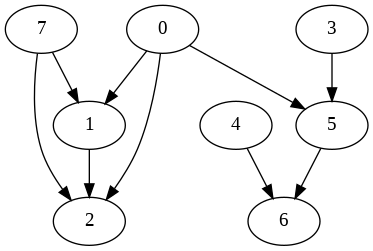

In [76]:
!gcc topologicalsort.c digraphmain.c dfsbfs.c graphsub.c stkque.c -o digraph
!cat ./graph.txt | ./digraph
#tmp.pngにグラフを作成
!python graph.py
#tmp.pngを表示
import IPython
IPython.display.display(IPython.display.Image('tmp.png'))

### DAG 2

In [77]:
%%file graph2.txt
5 5
0 1
0 2
1 3
4 1
2 4

Overwriting graph2.txt


0 -> 1 2 
1 -> 3 
2 -> 4 
3 -> 
4 -> 1 
[End] <- 3 <- 1 <- 4 <- 2 <- 0

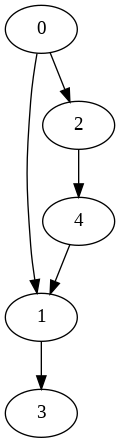

In [78]:
!cat ./graph2.txt | ./digraph
#tmp.pngにグラフを作成
!python graph.py
#tmp.pngを表示
import IPython
IPython.display.display(IPython.display.Image('tmp.png'))

### DAG 3

In [79]:
%%file graph3.txt
8 9
0 1
0 2
1 3
1 4
2 4
3 4
5 1
6 2
2 7

Overwriting graph3.txt


0 -> 1 2 
1 -> 3 4 
2 -> 4 7 
3 -> 4 
4 -> 
5 -> 1 
6 -> 2 
7 -> 
[End] <- 4 <- 3 <- 1 <- 7 <- 2 <- 0 <- 5 <- 6

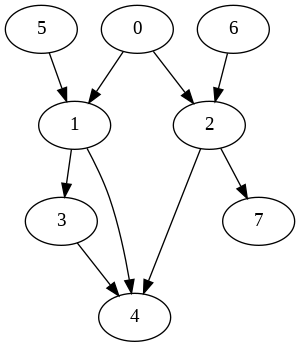

In [80]:
!cat ./graph3.txt | ./digraph
#tmp.pngにグラフを作成
!python graph.py
#tmp.pngを表示
import IPython
IPython.display.display(IPython.display.Image('tmp.png'))

# 発展課題  DAGの検出機能つきトポロジカルソート

課題1-2のトポロジカルソートのコードにDAGの検出機能を追加せよ

課題コードの中の、topological_sort_rec_isDAG関数を作成すれば良い。
DAGなら1、そうでないなら0を返す関数になっている。

## 課題コード

In [81]:
%%file topologicalsort_isDAG.c
#include<stdio.h>
#include<stdlib.h>
#include<math.h>
#include<time.h>
#include"dfsbfs.h"

#define NOT_CHECKED 0   /* まだ訪問していないノード */
#define CHECKED 1       /* 訪問済(チェックは終わった)ノード */
#define ACTIVE  2       /* チェック中のノード */

int topological_sort_rec_isDAG(Node_Gr *node)
{
    int i;
    int is_dag = 1;
    Node_Gr *child;              // 子供を格納する変数
    node->checked=ACTIVE;        // nodeはここでACTIVEとなった。

      for (i = 0; i < node->adj_size; i++) {
        child = node->adj[i];
        if (child->checked == ACTIVE) {
            return 0;
        }
        if (child->checked == NOT_CHECKED) {
            is_dag = topological_sort_rec_isDAG(child);
            if (is_dag == 0) return 0;
        }
    }

    node->checked = CHECKED;  // チェック完了

    printf(" <- %d", node->id);  // 帰りがけ順に出力
    return is_dag;
}

void topological_sort(Node_Gr **nodes, int node_size)
{
    int i;
    Node_Gr *start, *node,*child;
    int is_dag;

    for(i=0;i<node_size;i++) nodes[i]->checked=NOT_CHECKED;// 最初に0として初期化

    printf("[End]"); // 最初に終端マークを表示しとく
    while(1){
      for(i=0;i<node_size;i++) { //全てチェックされるまで繰り返す。
        if(nodes[i]->checked==NOT_CHECKED) break;
      }
      if(i>=node_size) break; //全てのノードがチェックされた。
      is_dag = topological_sort_rec_isDAG(nodes[i]);
      if (is_dag == 0)
          break;
    }
    if (is_dag) {
        printf("\nis DAG\n");
    } else {
        printf("\nis not DAG\n");
    }
}

Overwriting topologicalsort_isDAG.c


### main 関数

In [82]:
%%file digraphmain.c
#include<stdio.h>
#include<stdlib.h>
#include"dfsbfs.h"

int main()
{
    Node_Gr **nodes;
    Node_Gr *start;
    int node_size, num_edge;
    int i,target;

    nodes = make_arbitrary_digraph(&node_size); //入力データからグラフ作成
    print_adjacency_info(nodes, node_size);     // 隣接情報を表示
    print_digraph_info(nodes, node_size);       // pythonコードを出力

    topological_sort(nodes, node_size);         // トポロジカルソート

    delete_graph(nodes, node_size);             // グラフの削除
    return(0);
}

Overwriting digraphmain.c


## 実行結果 確認

### DAG 1

In [83]:
%%file graph.txt
8 9
0 1
0 2
1 2
3 5
4 6
7 2
5 6
0 5
7 1

Overwriting graph.txt


0 -> 1 2 5 
1 -> 2 
2 -> 
3 -> 5 
4 -> 6 
5 -> 6 
6 -> 
7 -> 2 1 
[End] <- 2 <- 1 <- 6 <- 5 <- 0 <- 3 <- 4 <- 7
is DAG


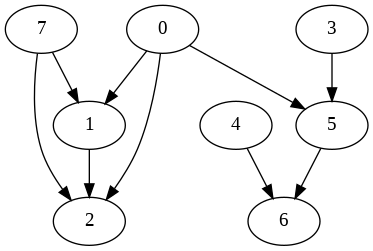

In [84]:
!gcc topologicalsort_isDAG.c digraphmain.c dfsbfs.c graphsub.c stkque.c -o digraph
!cat ./graph.txt | ./digraph
#tmp.pngにグラフを作成
!python graph.py
#tmp.pngを表示
import IPython
IPython.display.display(IPython.display.Image('tmp.png'))

### DAG 2

In [85]:
%%file graph2.txt
5 5
0 1
0 2
1 3
4 1
2 4

Overwriting graph2.txt


0 -> 1 2 
1 -> 3 
2 -> 4 
3 -> 
4 -> 1 
[End] <- 3 <- 1 <- 4 <- 2 <- 0
is DAG


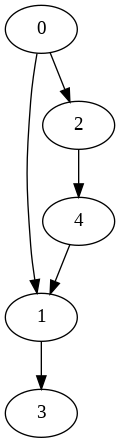

In [86]:
!cat ./graph2.txt | ./digraph
#tmp.pngにグラフを作成
!python graph.py
#tmp.pngを表示
import IPython
IPython.display.display(IPython.display.Image('tmp.png'))

### DAG 3

In [87]:
%%file graph3.txt
8 9
0 1
0 2
1 3
1 4
2 4
3 4
5 1
6 2
2 7

Overwriting graph3.txt


0 -> 1 2 
1 -> 3 4 
2 -> 4 7 
3 -> 4 
4 -> 
5 -> 1 
6 -> 2 
7 -> 
[End] <- 4 <- 3 <- 1 <- 7 <- 2 <- 0 <- 5 <- 6
is DAG


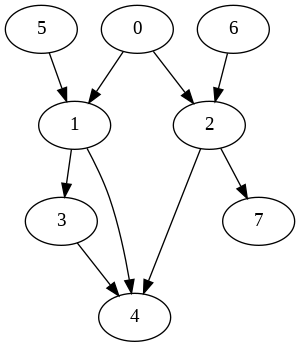

In [88]:
!cat ./graph3.txt | ./digraph
#tmp.pngにグラフを作成
!python graph.py
#tmp.pngを表示
import IPython
IPython.display.display(IPython.display.Image('tmp.png'))

### DAG でない例

In [89]:
%%file graph4.txt
5 6
0 1
0 2
1 3
4 1
2 4
3 4

Overwriting graph4.txt


0 -> 1 2 
1 -> 3 
2 -> 4 
3 -> 4 
4 -> 1 
[End]
is not DAG


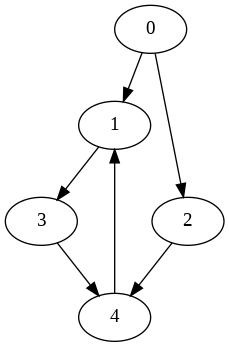

In [90]:
!cat ./graph4.txt | ./digraph
#tmp.pngにグラフを作成
!python graph.py
#tmp.pngを表示
import IPython
IPython.display.display(IPython.display.Image('tmp.png'))